# Pipelines + Gridsearch

In [2]:
# Standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix

In [3]:
# import data for subreddits
all_posts = pd.read_csv('./data/all.csv', index_col=[0], keep_default_na=False)
all_posts.head()

,title,created_utc,selftext,subreddit,author,media_only,permalink
0,Being rude and selfish does not help career pr...,1598916128,,science,HigherEdAvenger,False,/r/science/comments/ik91e0/being_rude_and_self...
1,How NASA and Chandrayaan discovered water on t...,1598911189,,science,7rillionaire,False,/r/science/comments/ik7lte/how_nasa_and_chandr...
2,Microbiome Analysis: Which Microbiome test is ...,1598911170,,science,Baron_ess,False,/r/science/comments/ik7lls/microbiome_analysis...
3,Study suggests religious belief does not confl...,1598910315,,science,CremationLily,False,/r/science/comments/ik7cfe/study_suggests_reli...
4,Space telescope using the Earth atmosphere as ...,1598910274,,science,KindlySecret8,False,/r/science/comments/ik7byl/space_telescope_usi...


### EDA

In [5]:
all_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        10000 non-null  object
 1   created_utc  10000 non-null  int64 
 2   selftext     10000 non-null  object
 3   subreddit    10000 non-null  object
 4   author       10000 non-null  object
 5   media_only   10000 non-null  bool  
 6   permalink    10000 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 556.6+ KB


In [6]:
all_posts.isna().sum()

title          0
created_utc    0
selftext       0
subreddit      0
author         0
media_only     0
permalink      0
dtype: int64

In [214]:
X = all_posts['title']
y = all_posts['subreddit']

In [215]:
X.shape

(10000,)

In [216]:
y.shape

(10000,)

In [217]:
y

0        science
1        science
2        science
3        science
4        science
         ...    
95    technology
96    technology
97    technology
98    technology
99    technology
Name: subreddit, Length: 10000, dtype: object

In [218]:
# Baseline accuracy; don't have to stratify 
y.value_counts(normalize=True)

technology    0.5
science       0.5
Name: subreddit, dtype: float64

In [219]:
# changing subreddits into binary
y = np.where(y == 'science', 1, 0)
y

array([1, 1, 1, ..., 0, 0, 0])

In [220]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=151)

In [222]:
# lemmetizing words in both X_train and X_test
lem = WordNetLemmatizer()
X_train_lem = [lem.lemmatize(i) for i in X_train]
X_test_lem = [lem.lemmatize(i) for i in X_test]

In [223]:
# instantiating the vectorizers and models I will use in my pipeline and grid searches below
cvec = CountVectorizer()
tvec = TfidfVectorizer()
log_r = LogisticRegression()
bayes = MultinomialNB()

### Pipeline + GridSearchCV: WordNetLemmetizer, CountVectorizer, LogisticRegression

In [224]:
pipe = make_pipeline(cvec, log_r)
params = {'countvectorizer__stop_words': ['english', None],
          'countvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'countvectorizer__min_df': [2, 3],
          'countvectorizer__max_df': [.9, .95],
          'countvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)],
          'logisticregression__C': [0.01, 0.5, 1]
         }

In [225]:
grid = GridSearchCV(pipe, params, n_jobs=-1, cv=5)

In [226]:
grid.fit(X_train_lem, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 0.95],
                         'countvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'countvectorizer__min_df': [2, 3],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'countvectorizer__stop_words': ['english', None],
                         'logisticregression__C': [0.01, 0.5, 1]})

In [227]:
grid.score(X_test_lem, y_test)

0.892

In [228]:
grid.score(X_train_lem, y_train)

0.9730666666666666

In [229]:
grid.best_params_

{'countvectorizer__max_df': 0.9,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'logisticregression__C': 1}

In [230]:
grid_df = pd.DataFrame(grid.cv_results_)
grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_df,param_countvectorizer__max_features,param_countvectorizer__min_df,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.366431,0.028913,0.055199,0.004073,0.9,None,2,"(1, 1)",english,0.01,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.822000,0.816000,0.805333,0.803333,0.804000,0.810133,0.007512,433
1,0.348229,0.008796,0.052000,0.001673,0.9,None,2,"(1, 1)",english,0.5,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.895333,0.895333,0.882000,0.890000,0.876000,0.887733,0.007632,63
2,0.385031,0.013580,0.051801,0.005381,0.9,None,2,"(1, 1)",english,1,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.894667,0.898667,0.887333,0.892000,0.879333,0.890400,0.006648,15
3,0.350629,0.031856,0.067204,0.009262,0.9,None,2,"(1, 1)",None,0.01,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.801333,0.810667,0.784000,0.789333,0.794667,0.796000,0.009314,529
4,0.620275,0.028280,0.068977,0.005089,0.9,None,2,"(1, 1)",None,0.5,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.891333,0.897333,0.894667,0.888000,0.884000,0.891067,0.004725,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,1.372547,0.074392,0.162147,0.012521,0.95,5000,3,"(1, 4)",english,0.5,"{'countvectorizer__max_df': 0.95, 'countvector...",0.887333,0.894000,0.884000,0.886667,0.874000,0.885200,0.006496,139
572,1.405789,0.089344,0.186517,0.020235,0.95,5000,3,"(1, 4)",english,1,"{'countvectorizer__max_df': 0.95, 'countvector...",0.884000,0.892000,0.884000,0.889333,0.876000,0.885067,0.005491,149
573,2.248653,0.081300,0.291032,0.042329,0.95,5000,3,"(1, 4)",None,0.01,"{'countvectorizer__max_df': 0.95, 'countvector...",0.802667,0.812000,0.788667,0.797333,0.794667,0.799067,0.007884,487
574,2.402097,0.033989,0.261801,0.027488,0.95,5000,3,"(1, 4)",None,0.5,"{'countvectorizer__max_df': 0.95, 'countvector...",0.880667,0.896667,0.889333,0.885333,0.883333,0.887067,0.005571,83


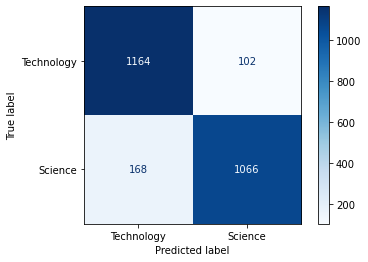

In [298]:
# View confusion matrix
plot_confusion_matrix(grid, X_test_lem, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);

### Pipeline + GridSearchCV: WordNetLemmetizer, CountVectorizer, MultinomialNB

In [232]:
pipe2 = make_pipeline(cvec, bayes)
params2 = {'countvectorizer__stop_words': ['english', None],
          'countvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'countvectorizer__min_df': [2, 3],
          'countvectorizer__max_df': [.9, .95],
          'countvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)]}

In [233]:
grid2 = GridSearchCV(pipe2, params2, n_jobs=-1, cv=5)

In [234]:
grid2.fit(X_train_lem, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 0.95],
                         'countvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'countvectorizer__min_df': [2, 3],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'countvectorizer__stop_words': ['english', None]})

In [235]:
grid2.score(X_test_lem, y_test)

0.8884

In [236]:
grid2.score(X_train_lem, y_train)

0.9461333333333334

In [237]:
grid2.best_params_

{'countvectorizer__max_df': 0.9,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 4),
 'countvectorizer__stop_words': 'english'}

In [238]:
grid2_df = pd.DataFrame(grid2.cv_results_)
grid2_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_df,param_countvectorizer__max_features,param_countvectorizer__min_df,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.426733,0.050497,0.096973,0.008877,0.9,None,2,"(1, 1)",english,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.896667,0.897333,0.896667,0.898000,0.879333,0.893600,0.007150,7
1,0.347003,0.030082,0.073244,0.007305,0.9,None,2,"(1, 1)",None,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.888000,0.896667,0.894667,0.895333,0.882667,0.891467,0.005323,9
2,0.704278,0.031718,0.137444,0.023073,0.9,None,2,"(1, 2)",english,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.897333,0.897333,0.895333,0.898667,0.882667,0.894267,0.005897,5
3,1.028866,0.035146,0.162996,0.011667,0.9,None,2,"(1, 2)",None,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.885333,0.894000,0.886667,0.890000,0.888000,0.888800,0.003023,15
4,1.191220,0.022654,0.188831,0.028877,0.9,None,2,"(1, 3)",english,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.898000,0.897333,0.896000,0.897333,0.883333,0.894400,0.005571,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.765632,0.051220,0.115450,0.004571,0.95,5000,3,"(1, 2)",None,"{'countvectorizer__max_df': 0.95, 'countvector...",0.884000,0.886667,0.882667,0.880000,0.884667,0.883600,0.002215,57
188,0.929862,0.038043,0.153273,0.007491,0.95,5000,3,"(1, 3)",english,"{'countvectorizer__max_df': 0.95, 'countvector...",0.891333,0.888000,0.889333,0.883333,0.877333,0.885867,0.005014,41
189,1.525852,0.117446,0.267036,0.043195,0.95,5000,3,"(1, 3)",None,"{'countvectorizer__max_df': 0.95, 'countvector...",0.881333,0.888667,0.874667,0.877333,0.886667,0.881733,0.005327,83
190,1.433524,0.043075,0.195043,0.025189,0.95,5000,3,"(1, 4)",english,"{'countvectorizer__max_df': 0.95, 'countvector...",0.890000,0.888000,0.888667,0.881333,0.874667,0.884533,0.005772,55


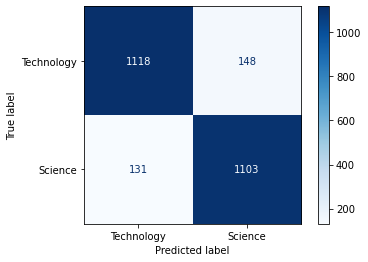

In [297]:
# View confusion matrix
plot_confusion_matrix(grid2, X_test_lem, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);

### Pipeline + GridSearchCV: WordNetLemmetizer, TfidfVectorizer, LogisticRegression

In [240]:
pipe3 = make_pipeline(tvec, log_r)
params3 = {'tfidfvectorizer__stop_words': ['english', None],
          'tfidfvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'tfidfvectorizer__min_df': [2, 3],
          'tfidfvectorizer__max_df': [.9, .95],
          'tfidfvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)],
          'logisticregression__C': [0.01, 0.5, 1]
         }

In [241]:
grid3 = GridSearchCV(pipe3, params3, n_jobs=-1, cv=5)

In [242]:
grid3.fit(X_train_lem, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.5, 1],
                         'tfidfvectorizer__max_df': [0.9, 0.95],
                         'tfidfvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'tfidfvectorizer__stop_words': ['english', None]})

In [243]:
grid3.score(X_test_lem, y_test)

0.8936

In [244]:
grid3.score(X_train_lem, y_train)

0.9586666666666667

In [245]:
grid3.best_params_

{'logisticregression__C': 1,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 3),
 'tfidfvectorizer__stop_words': 'english'}

In [246]:
grid3_df = pd.DataFrame(grid3.cv_results_)
grid3_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_tfidfvectorizer__max_df,param_tfidfvectorizer__max_features,param_tfidfvectorizer__min_df,param_tfidfvectorizer__ngram_range,param_tfidfvectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.548357,0.066936,0.078373,0.011730,0.01,0.9,None,2,"(1, 1)",english,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.878667,0.883333,0.887333,0.865333,0.876000,0.878133,0.007488,249
1,0.409164,0.034115,0.076623,0.014171,0.01,0.9,None,2,"(1, 1)",None,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.811333,0.827333,0.820667,0.819333,0.816667,0.819067,0.005226,507
2,0.831620,0.045683,0.104383,0.012764,0.01,0.9,None,2,"(1, 2)",english,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.881333,0.882667,0.886667,0.870667,0.880000,0.880267,0.005293,179
3,1.228624,0.079813,0.194304,0.025988,0.01,0.9,None,2,"(1, 2)",None,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.821333,0.827333,0.825333,0.826667,0.814000,0.822933,0.004928,487
4,1.532291,0.072143,0.187720,0.026666,0.01,0.9,None,2,"(1, 3)",english,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.878000,0.880000,0.884667,0.872667,0.877333,0.878533,0.003896,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.941963,0.019220,0.119083,0.013315,1,0.95,5000,3,"(1, 2)",None,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.882667,0.884000,0.880667,0.878000,0.878000,0.880667,0.002422,161
572,1.258702,0.081865,0.188533,0.025022,1,0.95,5000,3,"(1, 3)",english,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.891333,0.892667,0.894667,0.889333,0.883333,0.890267,0.003878,29
573,1.866310,0.143029,0.236401,0.024588,1,0.95,5000,3,"(1, 3)",None,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.884000,0.886000,0.881333,0.880000,0.876667,0.881600,0.003228,135
574,1.639857,0.104213,0.200569,0.038179,1,0.95,5000,3,"(1, 4)",english,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.890667,0.892667,0.894667,0.888000,0.882667,0.889733,0.004165,33


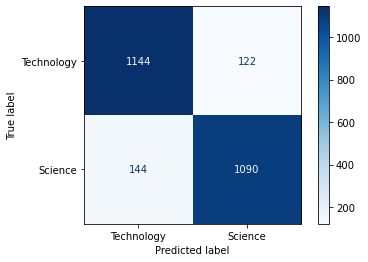

In [296]:
# View confusion matrix
plot_confusion_matrix(grid3, X_test_lem, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);

### Pipeline + GridSearchCV: WordNetLemmetizer, TfidfVectorizer, MultinomialNB

In [248]:
pipe4 = make_pipeline(tvec, bayes)
params4 = {'tfidfvectorizer__stop_words': ['english', None],
          'tfidfvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'tfidfvectorizer__min_df': [2, 3],
          'tfidfvectorizer__max_df': [.9, .95],
          'tfidfvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)]}

In [249]:
grid4 = GridSearchCV(pipe4, params4, n_jobs=-1, cv=5)

In [250]:
grid4.fit(X_train_lem, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfidfvectorizer__max_df': [0.9, 0.95],
                         'tfidfvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'tfidfvectorizer__stop_words': ['english', None]})

In [251]:
grid4.score(X_test_lem, y_test)

0.8924

In [252]:
grid4.score(X_train_lem, y_train)

0.9545333333333333

In [253]:
grid4.best_params_

{'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 4),
 'tfidfvectorizer__stop_words': 'english'}

In [254]:
grid4_df = pd.DataFrame(grid4.cv_results_)
grid4_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidfvectorizer__max_df,param_tfidfvectorizer__max_features,param_tfidfvectorizer__min_df,param_tfidfvectorizer__ngram_range,param_tfidfvectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.405381,0.044069,0.074228,0.008517,0.9,None,2,"(1, 1)",english,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.897333,0.902667,0.890000,0.898000,0.887333,0.895067,0.005603,7
1,0.324720,0.022734,0.088128,0.009721,0.9,None,2,"(1, 1)",None,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.892667,0.894667,0.896000,0.897333,0.882667,0.892667,0.005232,9
2,1.027501,0.087413,0.148841,0.043042,0.9,None,2,"(1, 2)",english,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.898667,0.902000,0.898000,0.896667,0.886667,0.896400,0.005174,5
3,1.356067,0.118909,0.203748,0.046618,0.9,None,2,"(1, 2)",None,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.892667,0.896667,0.894000,0.891333,0.887333,0.892400,0.003087,11
4,1.448277,0.052865,0.228193,0.039690,0.9,None,2,"(1, 3)",english,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.900000,0.900667,0.900000,0.896000,0.887333,0.896800,0.005014,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.921009,0.029226,0.168838,0.017788,0.95,5000,3,"(1, 2)",None,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.886000,0.891333,0.882000,0.876667,0.882667,0.883733,0.004837,97
188,1.127711,0.057416,0.176420,0.018195,0.95,5000,3,"(1, 3)",english,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.893333,0.890667,0.889333,0.884000,0.880667,0.887600,0.004611,45
189,1.566584,0.050805,0.219805,0.014353,0.95,5000,3,"(1, 3)",None,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.884000,0.894000,0.881333,0.876667,0.883333,0.883867,0.005679,93
190,1.467332,0.040424,0.212193,0.026123,0.95,5000,3,"(1, 4)",english,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.894000,0.889333,0.888667,0.882000,0.880000,0.886800,0.005119,53


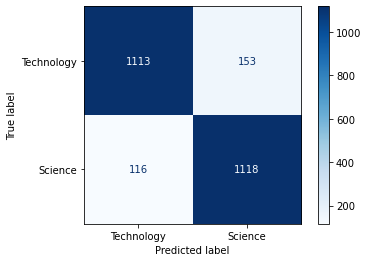

In [295]:
# View confusion matrix
plot_confusion_matrix(grid4, X_test_lem, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);

### Pipeline + GridSearchCV: CountVectorizer, LogisticRegression

In [256]:
pipe5 = make_pipeline(cvec, log_r)
params5 = {'countvectorizer__stop_words': ['english', None],
          'countvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'countvectorizer__min_df': [2, 3],
          'countvectorizer__max_df': [.9, .95],
          'countvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)],
          'logisticregression__C': [0.01, 0.5, 1]
         }

In [257]:
grid5 = GridSearchCV(pipe5, params5, n_jobs=-1, cv=5)

In [258]:
grid5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 0.95],
                         'countvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'countvectorizer__min_df': [2, 3],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'countvectorizer__stop_words': ['english', None],
                         'logisticregression__C': [0.01, 0.5, 1]})

In [259]:
grid5.score(X_test, y_test)

0.892

In [260]:
grid5.score(X_train, y_train)

0.9730666666666666

In [261]:
grid5.best_params_

{'countvectorizer__max_df': 0.9,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'logisticregression__C': 1}

In [262]:
grid5_df = pd.DataFrame(grid5.cv_results_)
grid5_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_df,param_countvectorizer__max_features,param_countvectorizer__min_df,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.570805,0.080448,0.114850,0.033023,0.9,None,2,"(1, 1)",english,0.01,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.822000,0.816000,0.805333,0.803333,0.804000,0.810133,0.007512,433
1,0.616318,0.076201,0.087960,0.006987,0.9,None,2,"(1, 1)",english,0.5,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.895333,0.895333,0.882000,0.890000,0.876000,0.887733,0.007632,67
2,0.736383,0.043316,0.088026,0.016519,0.9,None,2,"(1, 1)",english,1,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.894667,0.898667,0.887333,0.892000,0.879333,0.890400,0.006648,19
3,0.588674,0.040073,0.097336,0.018067,0.9,None,2,"(1, 1)",None,0.01,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.801333,0.810667,0.784000,0.789333,0.794667,0.796000,0.009314,529
4,0.804871,0.040978,0.106083,0.027647,0.9,None,2,"(1, 1)",None,0.5,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.891333,0.897333,0.894667,0.888000,0.884000,0.891067,0.004725,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,1.455785,0.084726,0.215933,0.041269,0.95,5000,3,"(1, 4)",english,0.5,"{'countvectorizer__max_df': 0.95, 'countvector...",0.887333,0.894000,0.884000,0.886667,0.874000,0.885200,0.006496,135
572,1.804223,0.054188,0.244963,0.036458,0.95,5000,3,"(1, 4)",english,1,"{'countvectorizer__max_df': 0.95, 'countvector...",0.884000,0.892667,0.884000,0.889333,0.876000,0.885200,0.005663,135
573,2.240161,0.129348,0.269684,0.019145,0.95,5000,3,"(1, 4)",None,0.01,"{'countvectorizer__max_df': 0.95, 'countvector...",0.802667,0.812000,0.788667,0.797333,0.794667,0.799067,0.007884,489
574,2.039599,0.072750,0.213181,0.007611,0.95,5000,3,"(1, 4)",None,0.5,"{'countvectorizer__max_df': 0.95, 'countvector...",0.880667,0.896667,0.889333,0.885333,0.883333,0.887067,0.005571,85


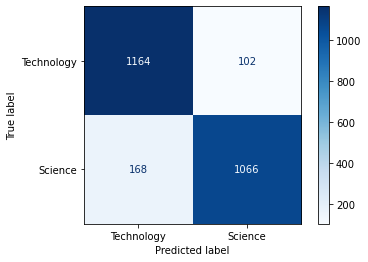

In [294]:
plot_confusion_matrix(grid5, X_test, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);

### Pipeline + GridSearchCV: CountVectorizer, MultinomialNB

In [264]:
pipe6 = make_pipeline(cvec, bayes)
params6 = {'countvectorizer__stop_words': ['english', None],
          'countvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'countvectorizer__min_df': [2, 3],
          'countvectorizer__max_df': [.9, .95],
          'countvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)]}

In [265]:
grid6 = GridSearchCV(pipe6, params6, n_jobs=-1, cv=5)

In [266]:
grid6.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 0.95],
                         'countvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'countvectorizer__min_df': [2, 3],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'countvectorizer__stop_words': ['english', None]})

In [267]:
grid6.score(X_test, y_test)

0.8888

In [268]:
grid6.score(X_train, y_train)

0.9458666666666666

In [269]:
grid6.best_params_

{'countvectorizer__max_df': 0.9,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 3),
 'countvectorizer__stop_words': 'english'}

In [270]:
grid6_df = pd.DataFrame(grid6.cv_results_)
grid6_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_df,param_countvectorizer__max_features,param_countvectorizer__min_df,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.442362,0.071610,0.079771,0.015877,0.9,None,2,"(1, 1)",english,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.896667,0.897333,0.896667,0.898000,0.878667,0.893467,0.007416,7
1,0.301396,0.009475,0.071419,0.009852,0.9,None,2,"(1, 1)",None,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.888000,0.896667,0.894667,0.895333,0.882000,0.891333,0.005546,9
2,0.674339,0.032355,0.109759,0.014994,0.9,None,2,"(1, 2)",english,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.897333,0.897333,0.895333,0.898667,0.882000,0.894133,0.006159,5
3,0.956171,0.059869,0.162060,0.012189,0.9,None,2,"(1, 2)",None,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.885333,0.894000,0.886667,0.890000,0.887333,0.888667,0.003070,15
4,1.187851,0.042667,0.164326,0.007298,0.9,None,2,"(1, 3)",english,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.898000,0.897333,0.896000,0.897333,0.882667,0.894267,0.005836,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.750080,0.035839,0.136807,0.035488,0.95,5000,3,"(1, 2)",None,"{'countvectorizer__max_df': 0.95, 'countvector...",0.884000,0.886667,0.882667,0.880000,0.884667,0.883600,0.002215,57
188,1.217312,0.113594,0.197236,0.028479,0.95,5000,3,"(1, 3)",english,"{'countvectorizer__max_df': 0.95, 'countvector...",0.891333,0.888000,0.889333,0.883333,0.877333,0.885867,0.005014,41
189,1.696705,0.099524,0.247705,0.026650,0.95,5000,3,"(1, 3)",None,"{'countvectorizer__max_df': 0.95, 'countvector...",0.881333,0.888667,0.874667,0.877333,0.886667,0.881733,0.005327,83
190,1.402962,0.033121,0.190350,0.011982,0.95,5000,3,"(1, 4)",english,"{'countvectorizer__max_df': 0.95, 'countvector...",0.890000,0.888000,0.888667,0.881333,0.874667,0.884533,0.005772,55


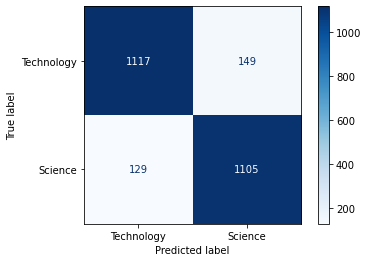

In [293]:
plot_confusion_matrix(grid6, X_test, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);

### Pipeline + GridSearchCV: TfidfVectorizer, LogisticRegression
**This model is comparable to one of my basic models**

In [272]:
pipe7 = make_pipeline(tvec, log_r)
params7 = {'tfidfvectorizer__stop_words': ['english', None],
          'tfidfvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'tfidfvectorizer__min_df': [2, 3],
          'tfidfvectorizer__max_df': [.9, .95],
          'tfidfvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)],
          'logisticregression__C': [0.01, 0.5, 1]
         }

In [273]:
grid7 = GridSearchCV(pipe7, params7, n_jobs=-1, cv=5)

In [274]:
grid7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.5, 1],
                         'tfidfvectorizer__max_df': [0.9, 0.95],
                         'tfidfvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'tfidfvectorizer__stop_words': ['english', None]})

In [275]:
grid7.score(X_test, y_test)

0.8936

In [276]:
grid7.score(X_train, y_train)

0.9586666666666667

In [277]:
grid7.best_params_

{'logisticregression__C': 1,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 3),
 'tfidfvectorizer__stop_words': 'english'}

In [278]:
grid7_df = pd.DataFrame(grid7.cv_results_)
grid7_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_tfidfvectorizer__max_df,param_tfidfvectorizer__max_features,param_tfidfvectorizer__min_df,param_tfidfvectorizer__ngram_range,param_tfidfvectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.627705,0.092428,0.135809,0.032999,0.01,0.9,None,2,"(1, 1)",english,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.878667,0.883333,0.887333,0.865333,0.876000,0.878133,0.007488,251
1,0.471907,0.017882,0.076307,0.009719,0.01,0.9,None,2,"(1, 1)",None,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.811333,0.827333,0.820667,0.819333,0.816667,0.819067,0.005226,507
2,0.983665,0.038056,0.133890,0.016764,0.01,0.9,None,2,"(1, 2)",english,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.881333,0.882667,0.886667,0.870667,0.880000,0.880267,0.005293,173
3,1.129013,0.057473,0.159712,0.014288,0.01,0.9,None,2,"(1, 2)",None,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.821333,0.827333,0.825333,0.826667,0.814000,0.822933,0.004928,487
4,1.178129,0.033869,0.147772,0.018730,0.01,0.9,None,2,"(1, 3)",english,"{'logisticregression__C': 0.01, 'tfidfvectoriz...",0.878000,0.880000,0.884667,0.872667,0.877333,0.878533,0.003896,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,1.110088,0.079110,0.180270,0.036238,1,0.95,5000,3,"(1, 2)",None,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.882667,0.884000,0.880667,0.878000,0.878000,0.880667,0.002422,159
572,1.179475,0.046552,0.142923,0.019585,1,0.95,5000,3,"(1, 3)",english,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.891333,0.892667,0.894667,0.889333,0.883333,0.890267,0.003878,27
573,1.350477,0.057432,0.169481,0.011291,1,0.95,5000,3,"(1, 3)",None,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.884000,0.884667,0.881333,0.880000,0.876667,0.881333,0.002891,143
574,1.328102,0.073317,0.170476,0.029918,1,0.95,5000,3,"(1, 4)",english,"{'logisticregression__C': 1, 'tfidfvectorizer_...",0.890667,0.892667,0.894667,0.888000,0.882667,0.889733,0.004165,35


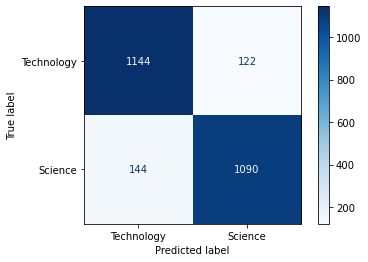

In [292]:
plot_confusion_matrix(grid7, X_test, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);

### Pipeline + GridSearchCV: TfidfVectorizer, MultinomialNB

In [280]:
pipe8 = make_pipeline(tvec, bayes)
params8 = {'tfidfvectorizer__stop_words': ['english', None],
          'tfidfvectorizer__max_features': [None, 1000, 2000, 3000, 4000, 5000],
          'tfidfvectorizer__min_df': [2, 3],
          'tfidfvectorizer__max_df': [.9, .95],
          'tfidfvectorizer__ngram_range': [(1, 1), (1,2), (1, 3), (1, 4)]}

In [281]:
grid8 = GridSearchCV(pipe8, params8, n_jobs=-1, cv=5)

In [282]:
grid8.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfidfvectorizer__max_df': [0.9, 0.95],
                         'tfidfvectorizer__max_features': [None, 1000, 2000,
                                                           3000, 4000, 5000],
                         'tfidfvectorizer__min_df': [2, 3],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (1, 4)],
                         'tfidfvectorizer__stop_words': ['english', None]})

In [283]:
grid8.score(X_test, y_test)

0.8924

In [284]:
grid8.score(X_train, y_train)

0.9544

In [285]:
grid8.best_params_

{'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 4),
 'tfidfvectorizer__stop_words': 'english'}

In [286]:
grid8_df = pd.DataFrame(grid8.cv_results_)
grid8_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidfvectorizer__max_df,param_tfidfvectorizer__max_features,param_tfidfvectorizer__min_df,param_tfidfvectorizer__ngram_range,param_tfidfvectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.450511,0.031348,0.105873,0.017942,0.9,None,2,"(1, 1)",english,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.897333,0.902667,0.890000,0.898000,0.886667,0.894933,0.005790,7
1,0.396435,0.010799,0.090560,0.009097,0.9,None,2,"(1, 1)",None,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.893333,0.894667,0.896000,0.897333,0.882000,0.892667,0.005497,9
2,0.814688,0.063803,0.131998,0.004335,0.9,None,2,"(1, 2)",english,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.898667,0.902000,0.898000,0.896667,0.886000,0.896267,0.005426,5
3,1.015434,0.032528,0.159506,0.006899,0.9,None,2,"(1, 2)",None,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.892667,0.896667,0.894000,0.891333,0.886667,0.892267,0.003309,11
4,1.064335,0.044440,0.149438,0.013173,0.9,None,2,"(1, 3)",english,"{'tfidfvectorizer__max_df': 0.9, 'tfidfvectori...",0.900000,0.900667,0.900000,0.896000,0.886667,0.896667,0.005266,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.750247,0.021771,0.120308,0.005500,0.95,5000,3,"(1, 2)",None,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.886000,0.891333,0.882000,0.876667,0.882667,0.883733,0.004837,97
188,0.891332,0.045619,0.145639,0.016413,0.95,5000,3,"(1, 3)",english,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.893333,0.890667,0.889333,0.884000,0.880667,0.887600,0.004611,45
189,1.489976,0.043866,0.231954,0.024663,0.95,5000,3,"(1, 3)",None,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.884000,0.894000,0.881333,0.876000,0.883333,0.883733,0.005851,97
190,1.377464,0.071245,0.197982,0.007251,0.95,5000,3,"(1, 4)",english,"{'tfidfvectorizer__max_df': 0.95, 'tfidfvector...",0.894000,0.889333,0.888667,0.882000,0.880000,0.886800,0.005119,51


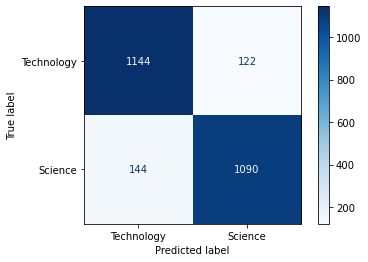

In [291]:
plot_confusion_matrix(grid7, X_test, y_test, cmap='Blues', values_format='d', display_labels=['Technology', 'Science']);